<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/DzDatascience/dz14_Pro_%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%94%D0%95%D0%9C%D0%9E_%D0%9F%D0%90%D0%9D%D0%95%D0%9B%D0%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:

создать нейронную сеть для распознавания марки автомобиля из 3х вариантов

сохраните веса

подготовить запуск модели "из коробки"

подготовить архив с готовой нейронной сетью для загрузки в демо-панель

## Загрузка библиотек


In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

## Задание гиперпараметров модели


Для начала необходимо правильно сгруппировать и организовать значения параметров, по которым будут производиться аугментация и обучение модели. Сперва зададим гиперпараметры для сети, которые включают директории для данных, значения для разделения выборок и входного размера изображений. Затем - значения для конфигурации самой аугментации, включающие пределы изменений положения авто, масштаба и яркости изображения. Далее, по доброй традиции, сохранённые значения будет легко передать в параметры соответствующих функций.

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.09                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 80                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

##Загрузка датасета и подготовка данных

Хорошим правилом при работе с любой задачей является наличие нескольких запусков обучения. Как минимум, этот подход позволяет сравнить разные точности обучения, поработать с гиперпараметрами и архитектурой сети, а для хорошего результата он необходим. Перед распаковкой изображений уничтожим все данные предыдущих пусков, что сделаем при помощи команд оболочки Linux:

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [ ]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

Определим список классов и их число:

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


Исходная база ещё не разделена на выборки. Вполне естественно, что для тестовых данных аугментация не требуется - они не участвуют в обучении модели. По этой причине данные для теста необходимо сразу отделить от обучающих и проверочных. Таким образом, часть изображений просто выделяется для тестирования модели и размещается в отдельной папке. Для разделения данных требуется не только создать папку и указать путь к ней; также нужно определить количество изображений в каждом из трёх классов, выделить некоторую их долю (заданную в гиперпараметрах) в каждом классе, и уже потом переместить файлы по указанному пути в папку. Разумеется, правильнее решить эту задачу при помощи цикла:

In [ ]:
int(1088 * 0.1)

108

In [ ]:
photo_1 = '/content/cars/Ferrari/car_Ferrari__0.png'
photo_1 = '/content/cars_test/Ferrari/car_Ferrari__0.png'

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 991 машин, для теста выделено файлов: 89
Размер класса Mercedes: 1057 машин, для теста выделено файлов: 95
Размер класса Renault: 1072 машин, для теста выделено файлов: 96
Общий размер базы: 3120, выделено для обучения: 2840, для теста: 280


## Аугментация и формирование выборок

Главная задача по увеличению базы изображений для обучения решается путем использования встроенного механизма Keras, он называется **ImageDataGenerator**. В параметрах генератора задаются все необходимые разрешения и пределы изменений исходного изображения - сдвиг, вращение, увеличение или отдаление, яркость и другие. Там же можно произвести нормализацию данных, что очень удобно (за это отвечает параметр **rescale**). Все параметры генератора называются соответсвующим их действию образом; удобства ради значения для них были заданы одноименно в верхнем регистре (ячейка гиперпараметров в начале ноутбука). Теперь остаётся только создать отдельный генератор для обучения, и отдельный для теста модели.

### Генераторы изображений и выборок

In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

Изображения для теста должны остаться в исходном виде. С ними будет проведена только нормализация.

Существует удобный метод генератора - `.flow_from_directory()`, который помогает извлечь из папок изображения для генерации, посчитать классы и автоматически вычислить метки классов для изображений. Было создано два отдельных генератора, поэтому тестовые изображения при прохождении через генератор не аугментируются, а только нормализуются. При этом обучающая и проверочная выборки будет иметь кол-во элементов в одном подаваемом объекте - BATCH_SIZE(24), а тестовая выборка включит в себя все тестовые изображения (batch_size равен test_count(341)), когда всего тестовых изображение тоже test_count((341))).

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2273 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Found 587 images belonging to 3 classes.


In [ ]:
len(train_generator[0]) == 24

False

In [ ]:
train_generator[0]
# (список пар изображений-меток)

(array([[[[0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          ...,
          [0.8980393 , 0.93725497, 1.        ],
          [0.91372555, 0.9568628 , 1.        ],
          [0.9607844 , 1.        , 1.        ]],
 
         [[0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          ...,
          [0.8980393 , 0.93725497, 1.        ],
          [0.9176471 , 0.9568628 , 1.        ],
          [0.9607844 , 1.        , 1.        ]],
 
         [[0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          [0.8588236 , 0.8470589 , 0.86274517],
          ...,
          [0.8980393 , 0.93725497, 1.        ],
          [0.9176471 , 0.9607844 , 1.        ],
          [0.96470594, 1.        , 1.        ]],
 
         ...,
 
         [[0.56078434, 0.5019608 , 0.42352945],
          [0.6    

In [ ]:
train_generator[0][0]
# (изображение, метка)

array([[[[0.5803922 , 0.5803922 , 0.5803922 ],
         [0.58431375, 0.58431375, 0.58431375],
         [0.58431375, 0.58431375, 0.58431375],
         ...,
         [0.5529412 , 0.54509807, 0.54901963],
         [0.5529412 , 0.54509807, 0.54901963],
         [0.5568628 , 0.54901963, 0.5529412 ]],

        [[0.5568628 , 0.5568628 , 0.5568628 ],
         [0.5568628 , 0.5568628 , 0.5568628 ],
         [0.56078434, 0.56078434, 0.56078434],
         ...,
         [0.5568628 , 0.5529412 , 0.5568628 ],
         [0.5529412 , 0.5529412 , 0.5529412 ],
         [0.5529412 , 0.54901963, 0.5529412 ]],

        [[0.5411765 , 0.5411765 , 0.53333336],
         [0.54509807, 0.54509807, 0.5372549 ],
         [0.54901963, 0.54901963, 0.5411765 ],
         ...,
         [0.5294118 , 0.5294118 , 0.5294118 ],
         [0.5294118 , 0.5294118 , 0.5294118 ],
         [0.5294118 , 0.5294118 , 0.5294118 ]],

        ...,

        [[0.5176471 , 0.47450984, 0.3529412 ],
         [0.5137255 , 0.46274513, 0.39607847]

In [ ]:
train_generator[0][0][0]
# изображение

array([[[0.6745098 , 0.67058825, 0.6784314 ],
        [0.6745098 , 0.67058825, 0.6784314 ],
        [0.7372549 , 0.7294118 , 0.7411765 ],
        ...,
        [0.76470596, 0.79215693, 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ]],

       [[0.6745098 , 0.67058825, 0.6784314 ],
        [0.6745098 , 0.67058825, 0.6784314 ],
        [0.7411765 , 0.73333335, 0.74509805],
        ...,
        [0.76470596, 0.79215693, 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ]],

       [[0.6745098 , 0.67058825, 0.6784314 ],
        [0.6745098 , 0.67058825, 0.6784314 ],
        [0.74509805, 0.7372549 , 0.7490196 ],
        ...,
        [0.7607844 , 0.78823537, 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ],
        [0.7607844 , 0.7843138 , 0.8313726 ]],

       ...,

       [[0.6862745 , 0.6431373 , 0.56078434],
        [0.7176471 , 0.6745098 , 0.5882353 ],
        [0.70980394, 0

In [ ]:
train_generator[0][0][1]
# метка

array([[[0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        ...,
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138]],

       [[0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        ...,
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138]],

       [[0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        ...,
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138]],

       ...,

       [[0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        [0.9843138, 0.9843138, 0.9843138],
        ...,
        [0.9843138, 0.9843

In [ ]:
#curr
#  batch
#    x_train
#    y_train
#next
#  batch
#    x_train
#    y_train

In [ ]:
#  batch
#    x_train
#    y_train

In [ ]:
class Some:
  def __init__(self, array):
    self.array = array
  def run(self):
    return '123'

  def __len__(self):
    return len(self.array)


In [ ]:
sss = Some([1,2,3,4,5])

In [ ]:
sss.run()

'123'

In [ ]:
len(sss.array)

5

In [ ]:
len(sss)

5

In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 95
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 24
Формы данных      тестовой выборки: (280, 64, 128, 3), (280, 3), батчей: 3

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


In [ ]:
len(train_generator)

95

In [ ]:
len(train_generator[0])

2

In [ ]:
x_train, y_train = train_generator[0]

In [ ]:
len(x_train), len(y_train)

(24, 24)

In [ ]:
y_train[0].shape

(3,)

In [ ]:
x_train[0].shape

(64, 128, 3)

In [ ]:
#batches
  #x_train
    #batch
     #изображение
  #y_train
   #batch
      #метка

### Проверка работы генераторов выборок

Посмотрите, как работают генераторы выборок. Для начала позапускайте следующую ячейку несколько раз. Аугментация работает "на лету".

Индексы для примера выбраны такие: `[1][0][2]`, что означает:
 - **1**: номер батча в выборке. Сам батч - это кортеж (**x_train, y_train**) с примерами и метками классов;
 - **0**: первый элемент в кортеже, то есть сами изображения. Под индексом **1** будут метки классов в формате **one hot encoding** для изображений;
 - **2**: номер картинки в батче.

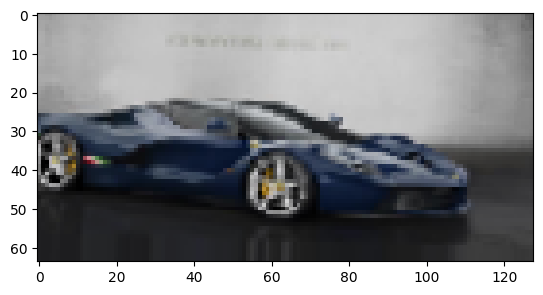

In [ ]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

Сама же картинка представлена в виде трехмерного массива нормализованных пикселей (от **0** до **1**):

In [ ]:
train_generator[1][0][2]

array([[[0.5137255 , 0.5137255 , 0.5137255 ],
        [0.5137255 , 0.5137255 , 0.5137255 ],
        [0.50980395, 0.50980395, 0.50980395],
        ...,
        [0.43921572, 0.43921572, 0.43921572],
        [0.43921572, 0.43921572, 0.43921572],
        [0.43921572, 0.43921572, 0.43921572]],

       [[0.52156866, 0.52156866, 0.52156866],
        [0.5137255 , 0.5137255 , 0.5137255 ],
        [0.5058824 , 0.5058824 , 0.5058824 ],
        ...,
        [0.43921572, 0.43921572, 0.43921572],
        [0.43921572, 0.43921572, 0.43921572],
        [0.43921572, 0.43921572, 0.43921572]],

       [[0.5254902 , 0.5254902 , 0.5254902 ],
        [0.52156866, 0.52156866, 0.52156866],
        [0.5058824 , 0.5058824 , 0.5058824 ],
        ...,
        [0.44705886, 0.44705886, 0.44705886],
        [0.44705886, 0.44705886, 0.44705886],
        [0.44705886, 0.44705886, 0.44705886]],

       ...,

       [[0.16078432, 0.16078432, 0.16078432],
        [0.15686275, 0.15686275, 0.15686275],
        [0.14901961, 0

Теперь создадим функцию для удобного просмотра сразу множества картинок из заданного батча. Для отрисовки нескольких изображений используем функцию `.subplots()` библиотеки **matplolib.pyplot**.



In [ ]:
0,1,2,3,4      --- 0, 1, 2, 3, 4
5,6,7,8,9      --- 0, 1, 2, 3, 4
10,11,12,13,14 --- 0, 1, 2, 3, 4
....

In [ ]:
x_train, y_train = train_generator[0]

In [ ]:
batch = train_generator[0]

In [ ]:
batch[0][0]

array([[[0.80392164, 0.8000001 , 0.83921576],
        [0.8431373 , 0.83921576, 0.8705883 ],
        [0.8470589 , 0.8431373 , 0.86666673],
        ...,
        [0.5764706 , 0.54901963, 0.48627454],
        [0.57254905, 0.54509807, 0.4784314 ],
        [0.5882353 , 0.5529412 , 0.48235297]],

       [[0.86666673, 0.86274517, 0.8862746 ],
        [0.9058824 , 0.8941177 , 0.909804  ],
        [0.91372555, 0.8980393 , 0.909804  ],
        ...,
        [0.67058825, 0.6039216 , 0.53333336],
        [0.6862745 , 0.6156863 , 0.54509807],
        [0.7019608 , 0.62352943, 0.54901963]],

       [[0.9568628 , 0.94117653, 0.9176471 ],
        [1.        , 1.        , 0.97647065],
        [0.98823535, 0.9725491 , 0.9450981 ],
        ...,
        [0.6392157 , 0.5764706 , 0.49803925],
        [0.62352943, 0.5686275 , 0.48627454],
        [0.6156863 , 0.5568628 , 0.47058827]],

       ...,

       [[0.6901961 , 0.61960787, 0.5803922 ],
        [0.6862745 , 0.61960787, 0.5764706 ],
        [0.6862745 , 0

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

Посмотрим на примеры картинок из генераторов. Можно запускать ячейки несколько раз - аугментация работает "на лету".

Примеры из обучающей выборки:

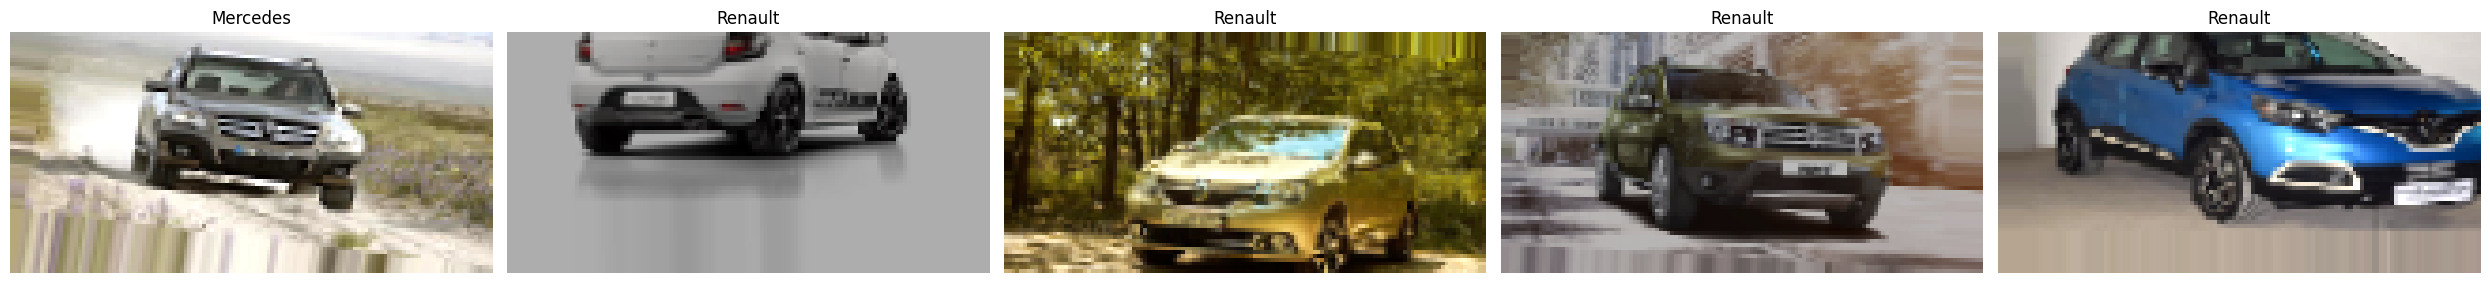

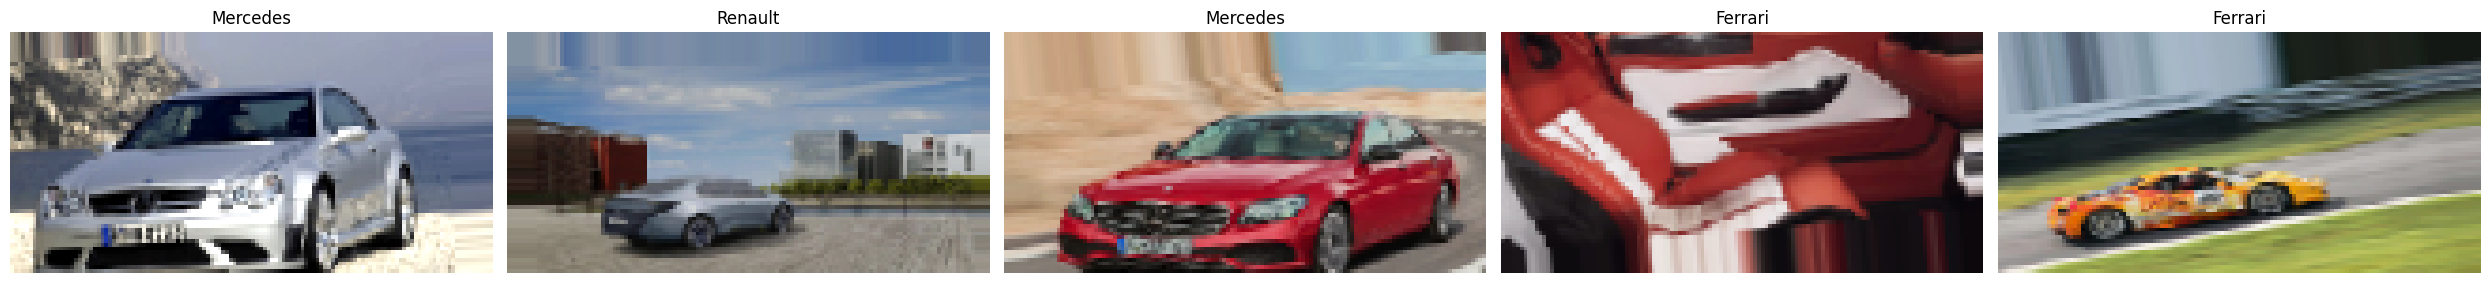

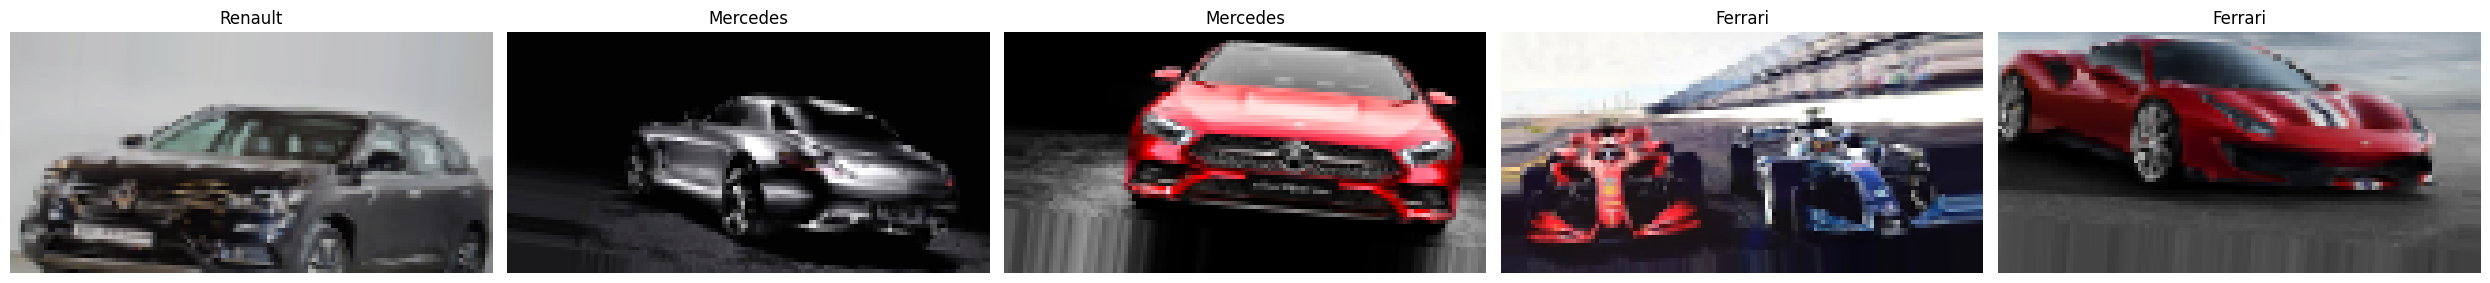

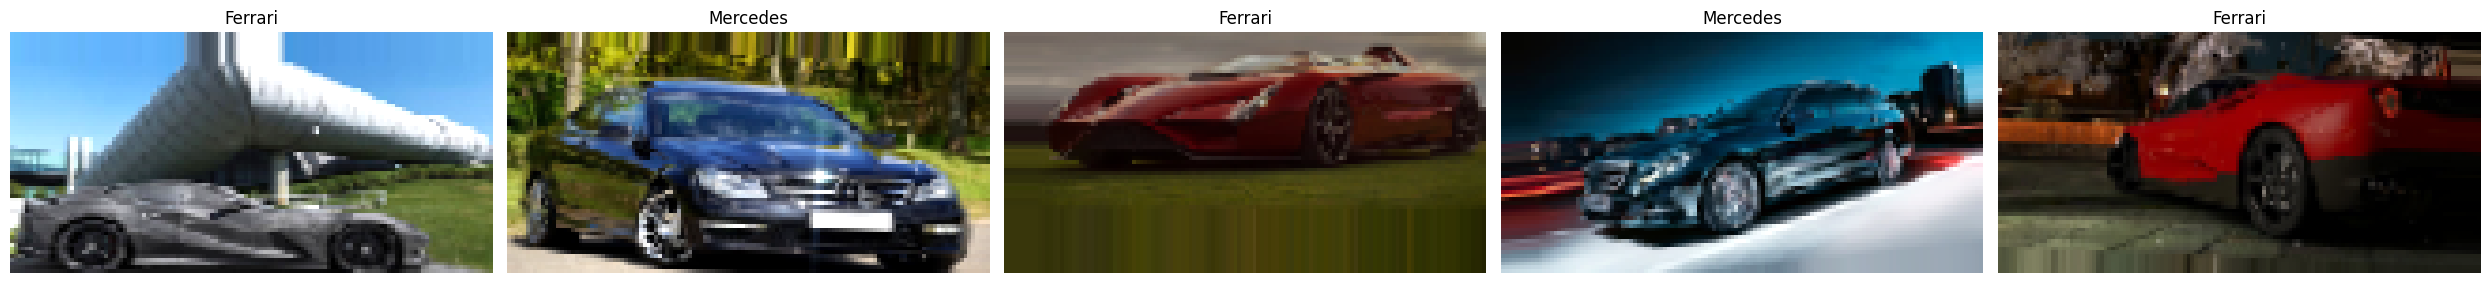

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

Примеры из проверочной выборки:

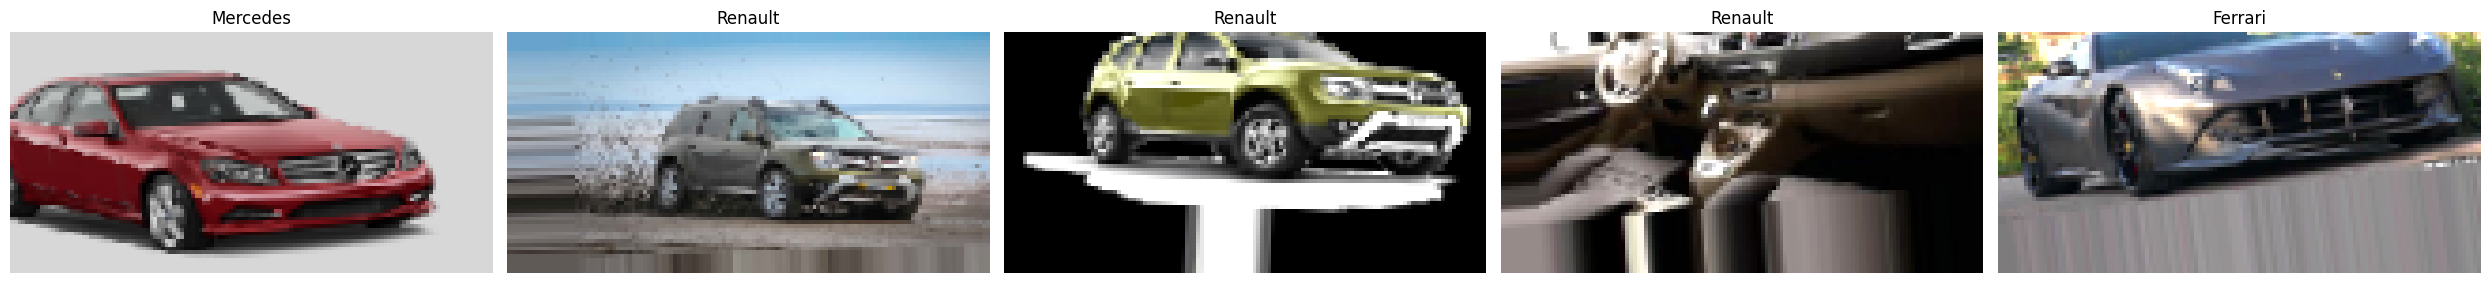

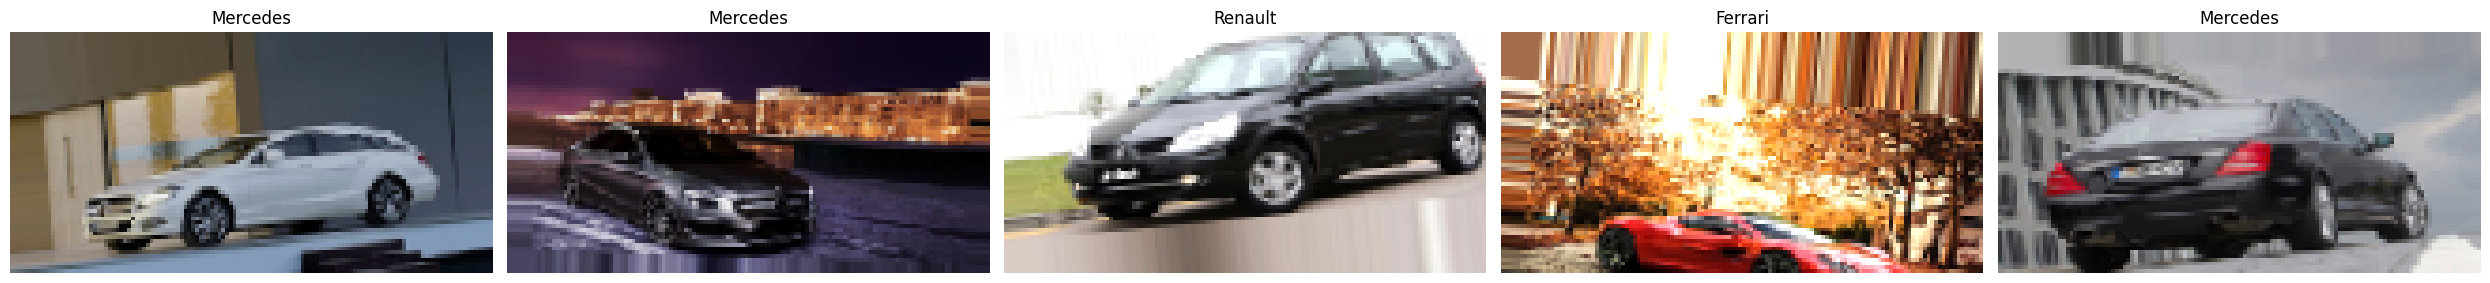

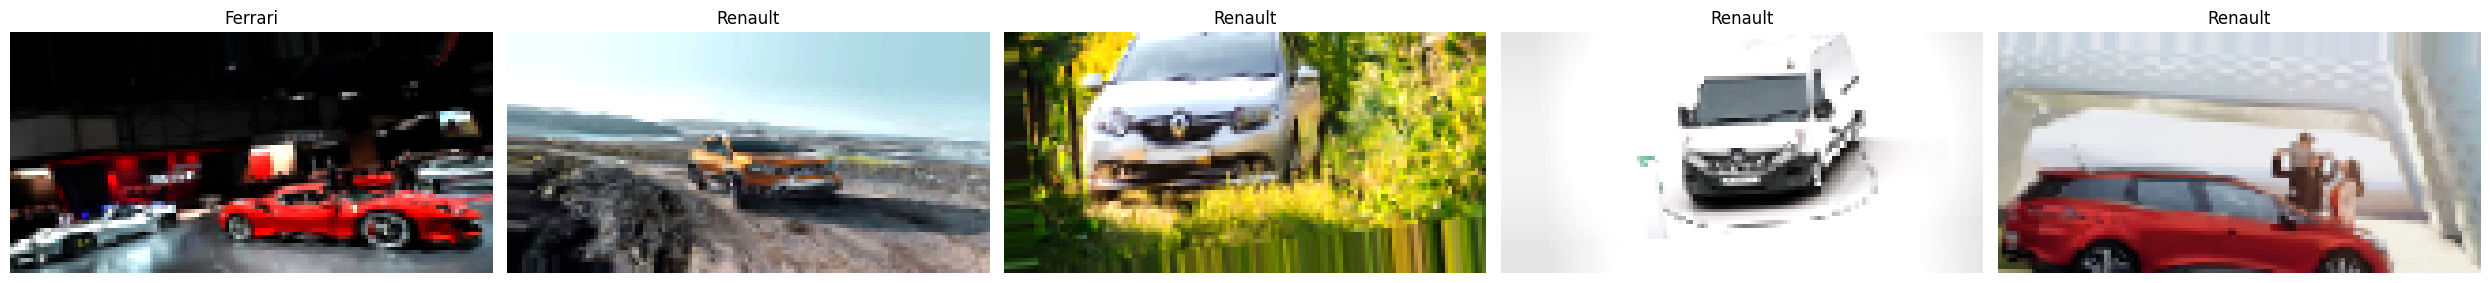

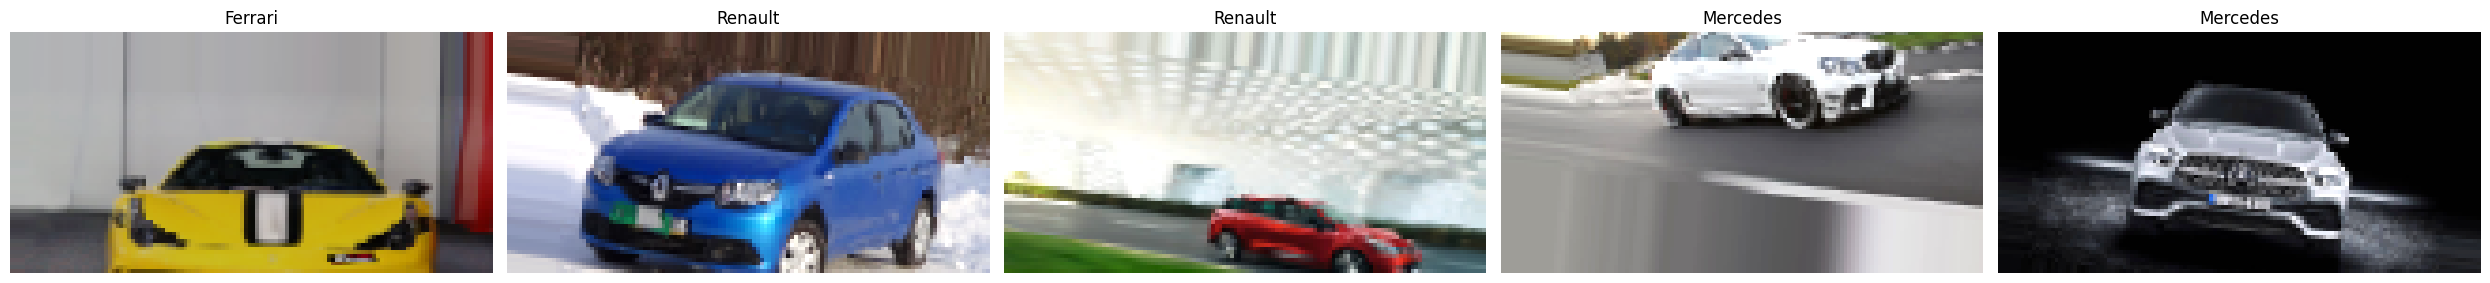

In [ ]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

Обратите внимание, что картинки тестового набора не аугментируются, а только приводятся к нужному размеру и нормализуются - содержимое батча не меняется при перезапусках ячейки:

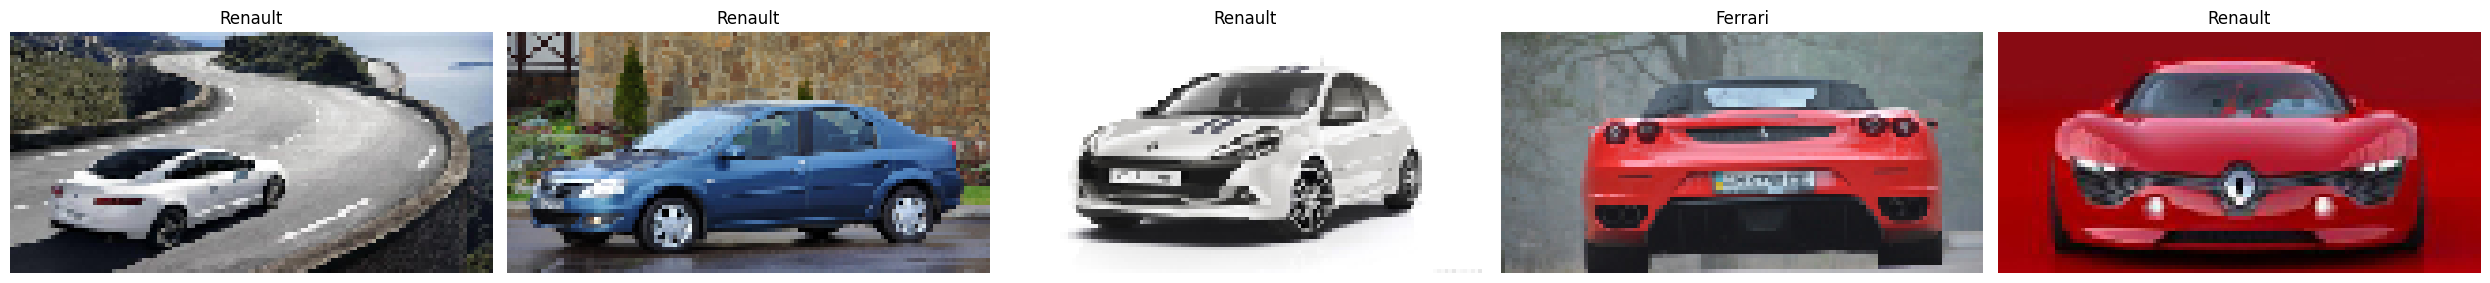

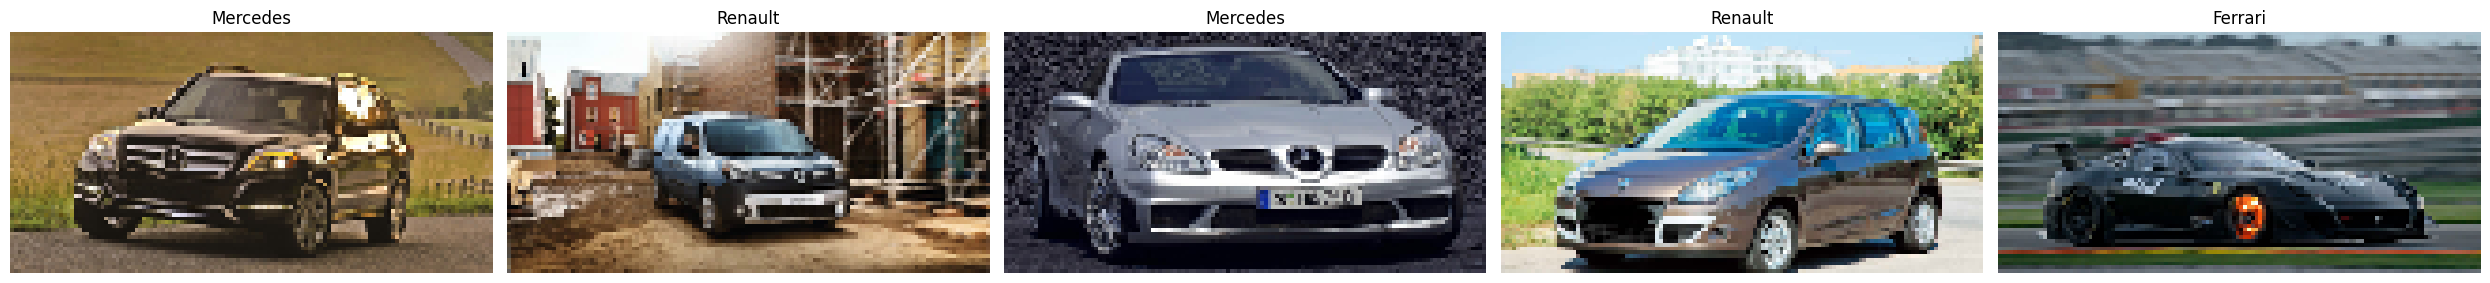

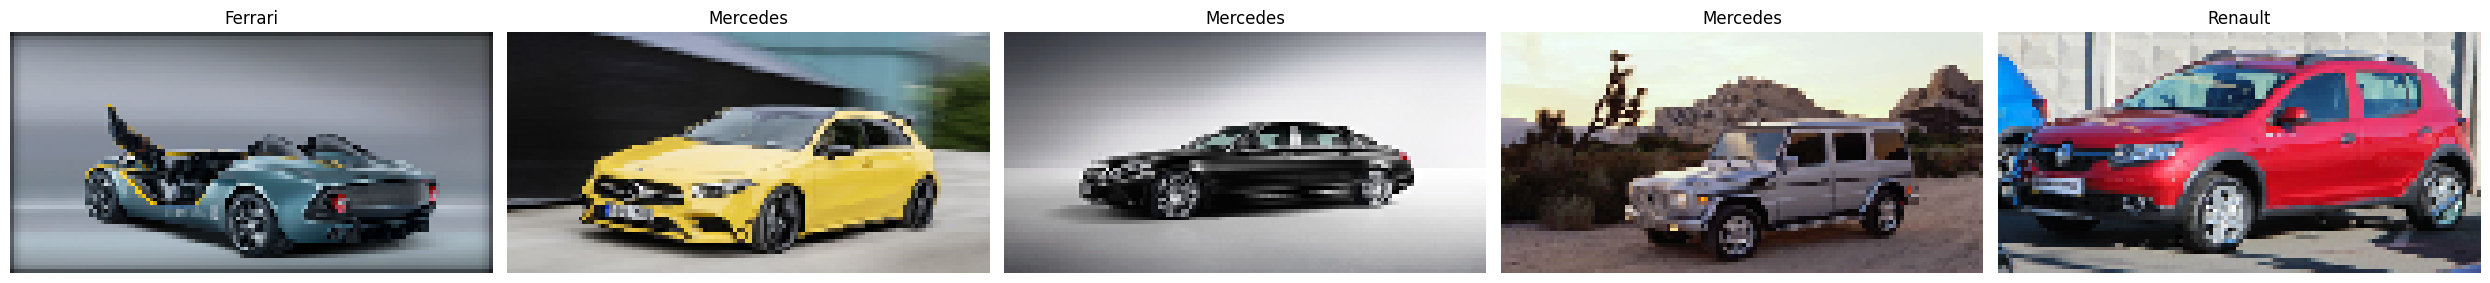

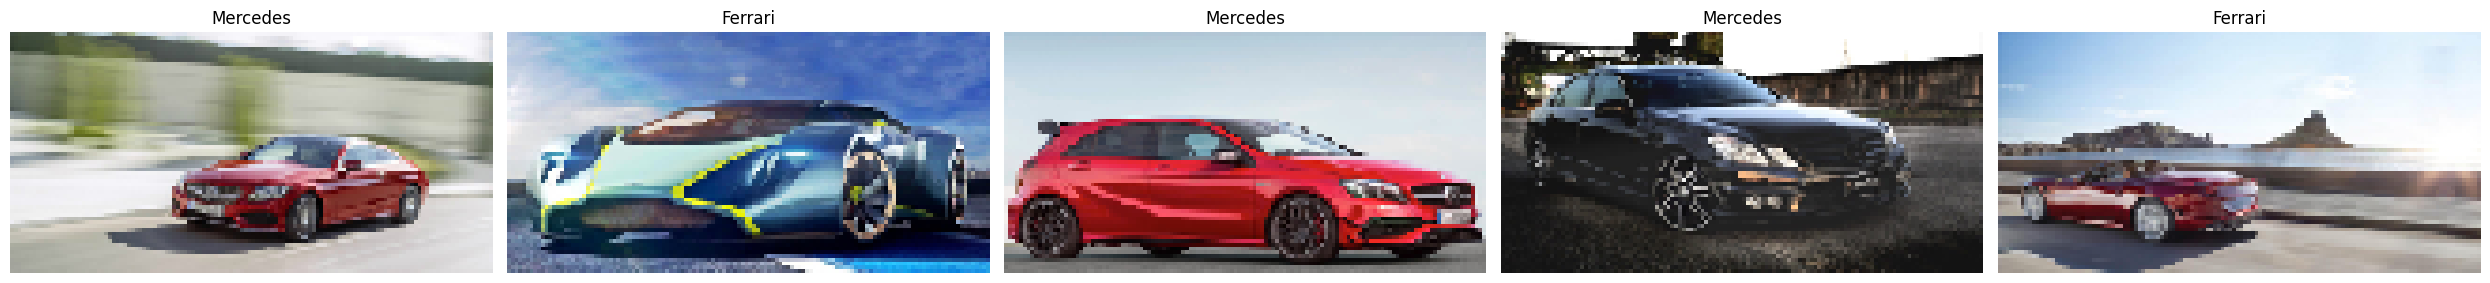

In [ ]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

В самом деле, тест модели проводится на картинках из реального датасета, которые никогда модели не предъявлялись. Аугментировать их нет необходимости.

## Создание и обучение модели нейронной сети

После того, как вы убедились в правильной работе объекта **ImageDataGenerator** на примерах из конкретного батча, можно перейти к обучению модели. Для этого будет удобнее сразу создать необходимые функции, включающие компиляцию, обучение, построение графиков ошибки и точности, оценку предсказаний модели. Впоследствие функции можно использовать многократно, избегая повторов и внесения ошибок в код.

###Сервисные функции


In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

###Архитектура модели нейронной сети


Теперь создадим модель, обучим ее на генерируемых данных и оценим работу на тестовых:

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 128, 256)      7168      
                                                                 
 batch_normalization_24 (Ba  (None, 64, 128, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 128, 256)      590080    
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 21, 42, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 21, 42, 256)       590080    
                                                                 
 batch_normalization_25 (Ba  (None, 21, 42, 256)      

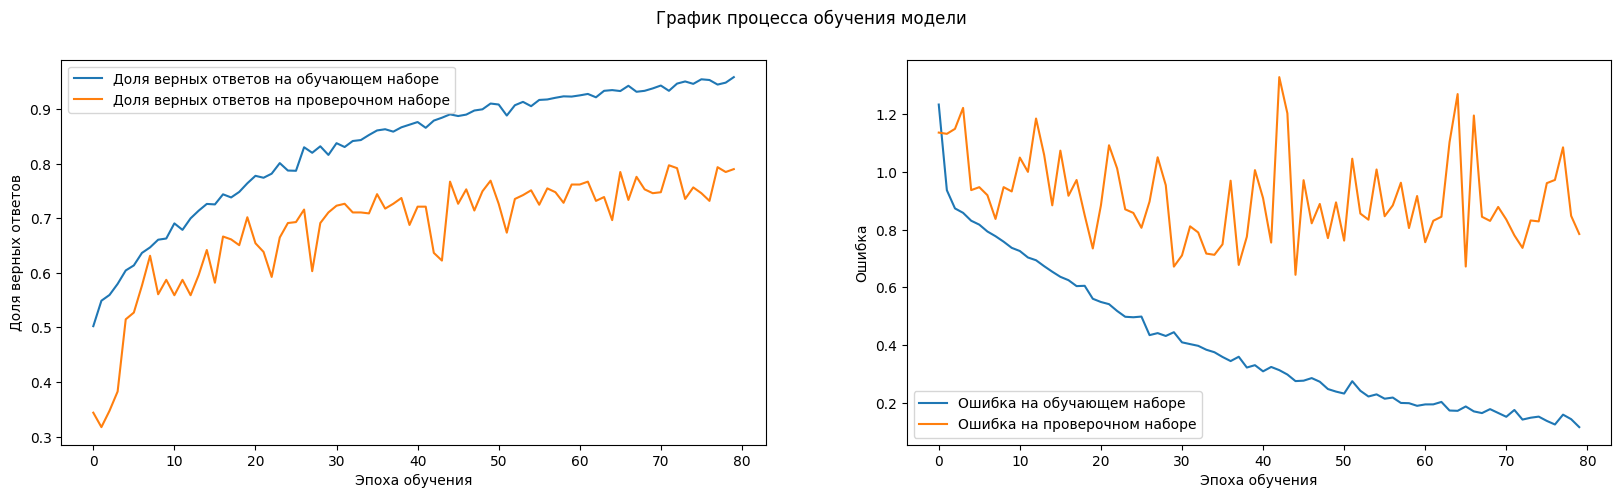

9/9 [==============================] - 0s 9ms/step


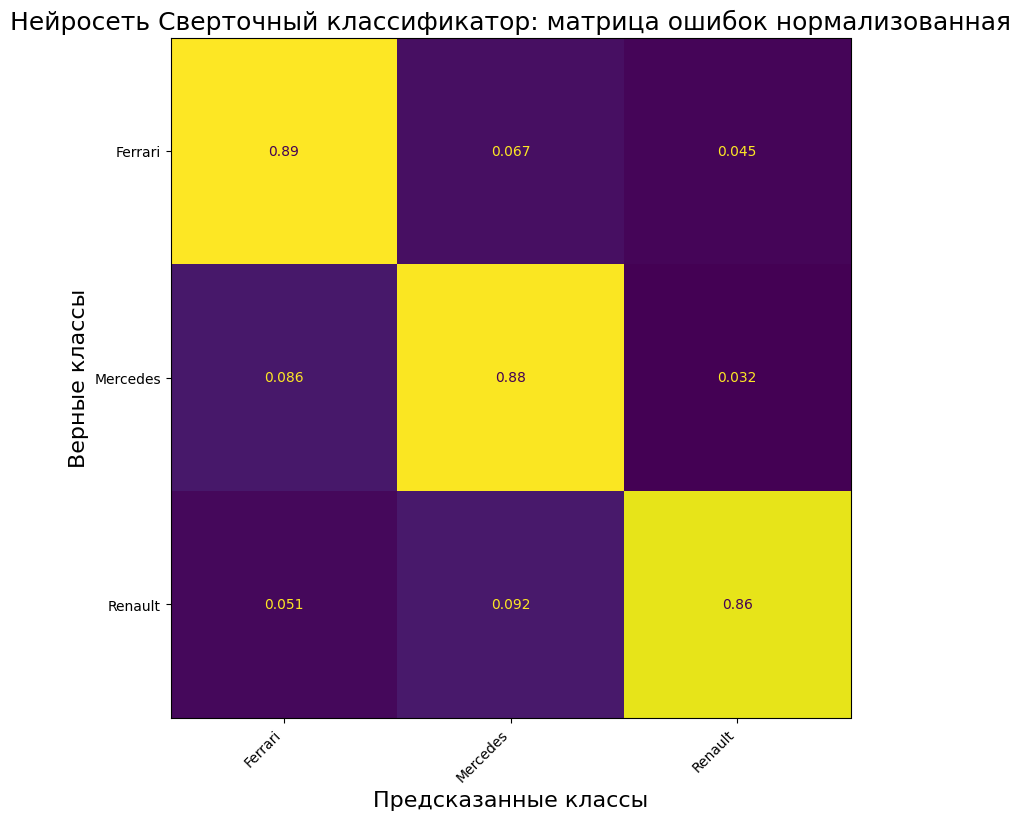

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Ferrari               89% сеть отнесла к классу Ferrari              - ВЕРНО :-)
Класс: Mercedes              88% сеть отнесла к классу Mercedes             - ВЕРНО :-)
Класс: Renault               86% сеть отнесла к классу Renault              - ВЕРНО :-)

Средняя точность распознавания:  88%


In [ ]:
# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.25))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.20))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.20))

# Слой преобразования многомерных данных в одномерные
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(CLASS_COUNT, activation='softmax'))


# Обучение модели и вывод оценки ее работы на тестовых данных
history = compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

In [ ]:
# Сохранение обученной модели полностью (веса и архитектура) после всех эпох

model_conv.save('model_fmr_all.h5_1')

Загрузите сохраненную модель в переменную model:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_fmr_all.h5_1')

Подготовьте тестовую картинку для подачи в модель:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Д з_Интеграция_нейронной_сети_на_ДЕМО-ПАНЕЛЬ/Автодлятеста'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


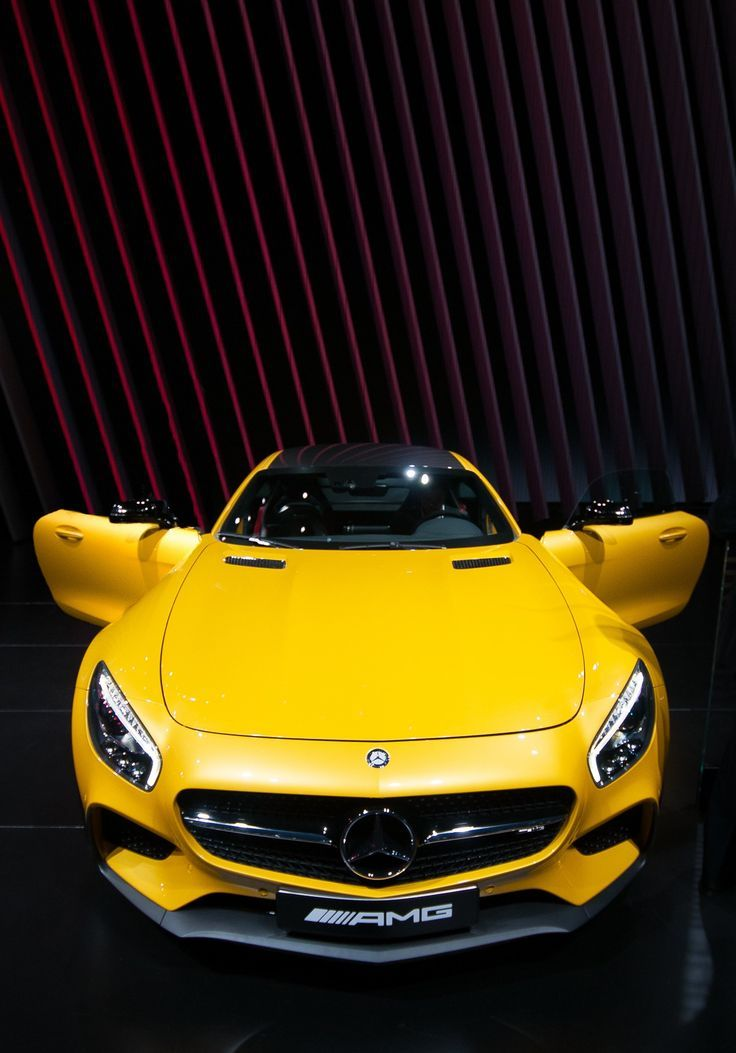

In [ ]:
# Просмотр тестового изображения

from PIL import Image

# Путь к файлу изображения
test_path = '//content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/0326f63d711a5e5f0547e39631f32e6e.jpg'
img = Image.open(test_path)

# Вывод изображения на экран
display(img)

In [ ]:
# Требуемый для модели размер изображения
img_width, img_height = 128, 64

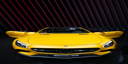

In [ ]:
from PIL import Image

# Путь к файлу изображения
test_path = '/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/0326f63d711a5e5f0547e39631f32e6e.jpg'

# Загрузка изображения
img = Image.open(test_path)

# Изменение размера изображения
img_resized = img.resize((img_width, img_height))

# Вывод измененного изображения на экран
display(img_resized)


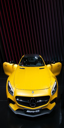

1/1 [==============================] - 0s 24ms/step
Результат распознавания:
Mercedes      99.99%
Ferrari        0.00%
Renault        0.01%

Изображен(а):  Mercedes


In [ ]:
# Подготовка изображения для подачи в модель НС

import numpy as np
from PIL import Image

# Предположим, что classes - это список названий классов
classes = ["Mercedes", "Ferrari", "Renault"]  # Замените на реальные названия классов

# Открытие картинки и изменение ее размера для соответствия входу модели
img_width, img_height = 64, 128
test_path = "/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/0326f63d711a5e5f0547e39631f32e6e.jpg"  # Пример пути к изображению
img = Image.open(test_path).resize((img_width, img_height))

# Проверка результата
display(img)

# Преобразование картинки в numpy-массив чисел с плавающей запятой и нормализация значений пикселей
image = np.array(img, dtype='float64') / 255.

# добавление оси для совпадения формы входа модели; получается батч из одного примера
image = np.expand_dims(image, axis=0)

# Распознавание изображения нейросетью
pred = model.predict(image)
print('Результат распознавания:')

for i, cl in enumerate(classes):
    # Вывод предсказания сети для каждого класса
    print('{:<14s}{:6.2%}'.format(cl, pred[0, i]))
print()

# Вычисление индекса класса с максимальным значением вероятности и вывод имени класса
cls_image = np.argmax(pred)
print('Изображен(а): ', classes[cls_image])


Запуск модели на демо-панели
Итак, у вас есть почти все необходимое для размещения модели нейронной сети на демо-панели. Осталась лишь пара штрихов.

Вначале создадим скрипт, который реализует распознавание изображения.

ВАЖНЫЕ МОМЕНТЫ в задании главной функции скрипта:

она должна иметь имя predict, так как сервер демо-панели будет вызывать функцию именно с таким именем;
она должна иметь первый обязательный аргумент img_path - путь к тестовому изображению на сервере демо-панели;
она должна иметь второй обязательный аргумент model_path - путь к модели на сервере демо-панели;
в скрипте должны быть импортированы все необходимые библиотеки для запуска модели, открытия и подготовки изображения.

In [ ]:
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5_1'):
    classes = {0: 'Mercedes',
               1: 'Ferrari',
               2: 'Renault'}

    model = load_model(model_path)

    img_width, img_height = 64, 128

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model.predict(image))

    print(classes[cls_image])

Попробуйте вызвать функцию predict() в ячейке Colab:

In [ ]:
predict(img_path='/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/0326f63d711a5e5f0547e39631f32e6e.jpg', model_path='model_fmr_all.h5_1')

1/1 [==============================] - 0s 135ms/step
Mercedes


Проверим

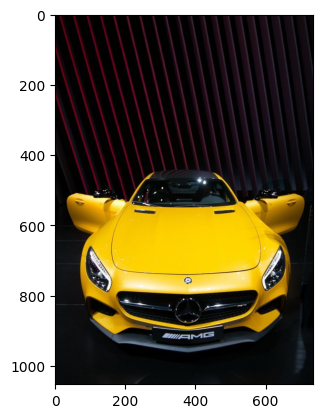

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/0326f63d711a5e5f0547e39631f32e6e.jpg'))
plt.show()

мерседес.

Теперь создадим текстовый файл с расширением .py и запишем в него созданный выше код (это и будет скрипт для демо-панели):

In [ ]:
# Сохранение кода скрипта в переменной text_code

text_code = '''
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5_1'):
    classes = {0: 'Mercedes',
               1: 'Ferrari',
               2: 'Renault'}

    model = load_model(model_path)

    img_width, img_height = 64, 128

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model.predict(image))

    print(classes[cls_image])

'''

# Запись содержимого переменной в файл скрипта

with open('script.py', 'w') as f:  # Создание / открытие файла
    f.write(text_code)             # Запись в файл значения переменной text_code

Следующим шагом подберем десять различных изображений, соответствующих классам датасета. Эти десять изображений будут отображаться на странице демо-панели в качестве пресетов. Загрузим их в директорию Colab под порядковыми номерами классов.

Вы можете взять абсолютно любые 10 изображений.

Здесь возьмем для этих целей файлы из тестовой папки:

In [ ]:
# Библиотека для работы с файлами
from shutil import copyfile

for i in range(1, 11):
    copyfile(f'/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста{i}.jpg')

Далее создадим текстовый файл label.txt с именами классов, распознаваемых моделью. Алгоритм аналогичный: сначала создаем текстовую переменную с именами классов, затем записываем текст в файл:

In [ ]:
label_txt = '''

Mercedes
Ferrari
Renault

'''

with open('label.txt', 'w') as f:  # Создание / открытие файла
    f.write(label_txt.strip())     # Запись в файл значения переменной

Осталось упаковать все файлы в один архив для отправки на сервер.

Это можно сделать вручную; в ячейке ниже показано, как процесс может быть запрограммирован на Python.

Важно! Перед запуском следующей ячейки кода убедитесь, что все необходимые файлы присутствуют в каталоге /content!

сохраненная модель model_fmr_all.h5_1;

скрипт script.py с функцией predict();

текстовый файл label.txt с именами классов;

10 изображений.

In [ ]:
import os
from zipfile import ZipFile

# Путь к каталогу с файлами
directory = '/content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста'

# Список всех файлов
integrate_files = ['model_fmr_all.h5_1', 'script.py', 'label.txt', *[f'{i}.jpg' for i in range(1, 11)]]

with ZipFile('/content/archive.zip', 'w') as zipArchive:
    for file in integrate_files:
        file_path = os.path.join(directory, file)  # Полный путь к файлу
        if os.path.exists(file_path):
            zipArchive.write(file_path)
        else:
            print(f'Файл {file_path} отсутствует!')



Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/model_fmr_all.h5_1 отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/script.py отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/label.txt отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/1.jpg отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/2.jpg отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/3.jpg отсутствует!
Файл /content/drive/MyDrive/Colab Notebooks/DATA_SCIENCE_Dz/14_Дз_Интеграция_нейронной_сети_на_ДЕМО_ПАНЕЛЬ/Автодлятеста/4.jpg отсут

Скачайте готовый Zip-архив себе на компьютер, чтобы далее отправить его на сервер:

In [ ]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='archive.zip')       # Скачивание готового архива

print('Архив загружен')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Архив загружен
